# Classifying YouTube videos to find true humpback whale encounters  - Keras CNN + RNN 

# Setup

In [11]:
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf #had to install using `conda install -c conda-forge tensorflow` since pip and conda were not working
import pandas as pd
import numpy as np
import os

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold

tf.__version__

'2.8.0'

# Define Hyperparameters

In [12]:
#need to find out what each hyperparameter is for
ROOT_DIR = os.path.dirname(os.path.abspath('video_classification_demo.ipynb'))

IMG_SIZE = 224
BATCH_SIZE = 64 
EPOCHS = 10 

MAX_SEQ_LENGTH = 31 #480 #31 #max frames per video (even if multiple clips)
NUM_FEATURES = 2048 #the number of features we extract from frames using InceptionV3 (kepts same as tutorial)

print(f"MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")
print(f"ROOT DIR: {ROOT_DIR}")

MAX_SEQ_LENGTH: 31
ROOT DIR: /mount/workspace


# Data Preparation

In this section, we reload the features that were extracted using InceptionV3 from our videos, as well as their masks and labels. 

In [15]:
# to reload our filled frame features, masks, and labels for unsplit dataset
all_frame_features_filled_middle = np.load('all_frame_features_filled_middle.npy')
all_frame_masks_filled_middle    = np.load('all_frame_masks_filled_middle.npy')
all_labels_filled_middle         = np.load('all_labels_filled_middle.npy')

print(f"ALL Frame features filled: {all_frame_features_filled_middle.shape}")
print(f"ALL Frame masks filled:    {all_frame_masks_filled_middle.shape}")
print(f"ALL Frame labels filled:   {all_labels_filled_middle.shape}")

ALL Frame features filled: (407, 31, 2048)
ALL Frame masks filled:    (407, 31)
ALL Frame labels filled:   (407, 1)


In [16]:
type(all_labels_filled_middle)

numpy.ndarray

# RNN Model for Prediction


### Fitting Model with Cross Validation

We use cross validation to find what the best accuracy for our model is based on our entire data. By doing this, every example has a chance to be part of the test set AND train set at some point

In [17]:
def get_model_name(k):
    return 'model_'+ k +'.h5'

def load_unsplit_dataset(unsplit_csv, check_shapes=True):
    X       = pd.read_csv(unsplit_csv) 
    y       = X['relevant'].to_frame()
    X       = X.drop(columns=['relevant'])

    if check_shapes:
        print(X.shape)
        print(y.shape)

    return X, y

In [21]:
#where to store our models 
# save_dir = '/models/'
url_dataset = 'youtube_humpback_whale_classification_dataset.csv'

#define the Stratified K-fold Cross Validator (use strat for equal num of class examples in folds)
fold_no   = 1
num_folds = 5
skfold    = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)

# Store Test Acc and Loss for K-fold Cross Validation model evaluation
test_acc_per_fold       = dict()
test_loss_per_fold      = dict()
histories_per_fold      = dict()
fold_train_test_indices = dict() #{'fold_model_name': [fold_train_index_list, fold_test_index_list]}

# Load in unsplit X and y (from data_v2) + reindex so our indices match with our save features, masks, labels arrays
X, y = load_unsplit_dataset(url_dataset)

for train_index, test_index in skfold.split(X, y):

    print('------------------------------------------------------------------------')
    print(f"Fold {fold_no}...")

    #get frame features and masks of train folds
    train_features_fold, train_masks_fold, train_labels_fold = all_frame_features_filled_middle[train_index], all_frame_masks_filled_middle[train_index], all_labels_filled_middle[train_index]
    test_features_fold,  test_masks_fold,  test_labels_fold  = all_frame_features_filled_middle[test_index],  all_frame_masks_filled_middle[test_index],  all_labels_filled_middle[test_index]
    
    #create + compile the model
    class_vocab          = [0, 1] 
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input           = keras.Input((MAX_SEQ_LENGTH, ), dtype="bool")
    
    
    #what if we switch out the GRU layers for LSTM layers?
    x                    = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x                    = keras.layers.GRU(8)(x)
    x                    = keras.layers.Dropout(0.5)(x)
    x                    = keras.layers.Dense(8, activation="relu")(x)
    output               = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model            = keras.Model([frame_features_input, mask_input], output)
    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) #ok to use sparse_categorical_crossentropy as long as we have 2 or more label classes

    #Fit data to model
    print(f'Training for fold {fold_no} ...')
    fold_model_name = get_model_name(str(fold_no) + '_cv')
    history = rnn_model.fit(   [train_features_fold, train_masks_fold], 
                               train_labels_fold,
                               validation_split = 0.1,
                               epochs = 10,
                               verbose= 0
                            )

    # Generate metrics on validation data
    test_loss, test_accuracy = rnn_model.evaluate([test_features_fold, test_masks_fold], test_labels_fold)

    print(f'TEST Metrics for Fold {fold_no}: Accuracy = {test_accuracy}     Loss = {test_loss}')

    #store the test accuracies and loss for each fold model
    test_acc_per_fold[fold_model_name]       = test_accuracy
    test_loss_per_fold[fold_model_name]      = test_loss
    histories_per_fold[fold_model_name]      = history
    fold_train_test_indices[fold_model_name] = [train_index, test_index]
    
    print('------------------------------------------------------------------------')

    # Increase fold number
    fold_no = fold_no + 1

(407, 6)
(407, 1)
------------------------------------------------------------------------
Fold 1...
Training for fold 1 ...
3/3 [==============================] - 0s 7ms/step - loss: 0.3754 - accuracy: 0.9146
TEST Metrics for Fold 1: Accuracy = 0.9146341681480408     Loss = 0.375435471534729
------------------------------------------------------------------------
------------------------------------------------------------------------
Fold 2...
Training for fold 2 ...
3/3 [==============================] - 0s 6ms/step - loss: 0.3331 - accuracy: 0.8537
TEST Metrics for Fold 2: Accuracy = 0.8536585569381714     Loss = 0.33311372995376587
------------------------------------------------------------------------
------------------------------------------------------------------------
Fold 3...
Training for fold 3 ...
3/3 [==============================] - 0s 6ms/step - loss: 0.3939 - accuracy: 0.8642
TEST Metrics for Fold 3: Accuracy = 0.8641975522041321     Loss = 0.393930047750473
------

In [22]:
test_acc_per_fold

{'model_1_cv.h5': 0.9146341681480408,
 'model_2_cv.h5': 0.8536585569381714,
 'model_3_cv.h5': 0.8641975522041321,
 'model_4_cv.h5': 0.8641975522041321,
 'model_5_cv.h5': 0.8148148059844971}

In [23]:
test_loss_per_fold

{'model_1_cv.h5': 0.375435471534729,
 'model_2_cv.h5': 0.33311372995376587,
 'model_3_cv.h5': 0.393930047750473,
 'model_4_cv.h5': 0.410473108291626,
 'model_5_cv.h5': 0.4174901247024536}

In [24]:
histories_per_fold

{'model_1_cv.h5': <keras.callbacks.History at 0x7fb7e4c61f70>,
 'model_2_cv.h5': <keras.callbacks.History at 0x7fb7ea413970>,
 'model_3_cv.h5': <keras.callbacks.History at 0x7fb7e43c1f40>,
 'model_4_cv.h5': <keras.callbacks.History at 0x7fb7e9b07790>,
 'model_5_cv.h5': <keras.callbacks.History at 0x7fb7d4474c70>}

In [25]:
fold_train_test_indices #structure: {'model name': [[fold_train_indices], [fold_test_indices]], 'model name 2': [...], ...}

{'model_1_cv.h5': [array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  17,  18,  19,  20,  21,  22,  24,  26,  27,  28,  29,  30,
          31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  45,
          46,  47,  50,  51,  52,  53,  55,  56,  57,  58,  59,  60,  61,
          62,  63,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          79,  80,  81,  83,  84,  85,  86,  87,  88,  90,  91,  93,  94,
          97,  98, 100, 102, 103, 105, 107, 108, 109, 110, 111, 112, 113,
         114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129,
         130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145,
         146, 147, 149, 151, 155, 158, 160, 162, 163, 164, 165, 167, 168,
         170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 182, 183, 184,
         185, 186, 187, 188, 191, 192, 194, 195, 196, 197, 198, 199, 201,
         202, 203, 204, 205, 206, 210, 211, 212, 213, 214, 216, 217, 218,
         219, 220, 22

In [171]:
#save dictionary of fold indices
with open('saved_models_v3/fold_indices.pkl', 'wb') as f:
    pickle.dump(fold_train_test_indices, f)
    
print('Done saving dictionary of fold train test indices')

Done saving dictionary of fold train test indices


In [26]:
cross_val_avg_accuracy = np.mean(list(test_acc_per_fold.values()))
cross_val_avg_loss     = np.mean(list(test_loss_per_fold.values()))

print(f"Average Accuracy with 5-fold Cross Validation: {cross_val_avg_accuracy}")
print(f"Average Loss with 5-fold Cross Validation:     {cross_val_avg_loss}")

Average Accuracy with 5-fold Cross Validation: 0.8623005270957946
Average Loss with 5-fold Cross Validation:     0.3860884964466095


# Inference

In [202]:
def prepare_single_video(frames):
    frame_mask     = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i,j,:] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1 #1 = not masked, 0 = masked

    return frame_features, frame_mask

#generates prediction and accuracy scores for a single video with model passed in
def sequence_prediction(path, model, silent=False):
    class_vocab = [0, 1] #label_processor.get_vocabulary()

    # Gather all its frames and add a batch dimension (frames has shape frames[None, ...])
    path   = path.split('.mp4')[0]
    frames = get_frames_for_all_clips(path, "video_clips/", ROOT_DIR)
    
    frame_features, frame_mask = prepare_single_video(frames)
    
    probabilities = model.predict([frame_features, frame_mask])[0]

    if silent == False:
        for i in np.argsort(probabilities)[::-1]:
            print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    return frames, probabilities

# This utility is for visualization. Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images, video_name, saveto_path):
    
    converted_images = images.astype(np.uint8)
    imageio.mimsave(f"{saveto_path}{video_name}.gif", converted_images, fps=10)
    return embed.embed_file(f"{saveto_path}{video_name}.gif")


In [ ]:
# classes = ['nonrelevant', 'relevant']

# #get max probability class for each row 
# for i in range(0, len(probabilities)):
#     video_predicted_class_probabilities = probabilities[i]

#     greatest_to_least_class     = np.argsort(video_predicted_class_probabilities)[::-1] #this returns the class labels in order of greatest probability to least probability predicted
#     predicted_class             = greatest_to_least_class[0] #the most confident class prediction is first (index 0)
#     predicted_class_probability = video_predicted_class_probabilities[predicted_class] #the actual probability of most confident class

#     print(video_predicted_class_probabilities)
#     print(f"{predicted_class} ({classes[predicted_class]}): {predicted_class_probability * 100:5.2f} %")
#     print('---------------')


## Metrics on Test Set(s) 
Getting accuracy, loss, confusion matrix, precision, recall, and f1 metrics for each model, then calculating the average

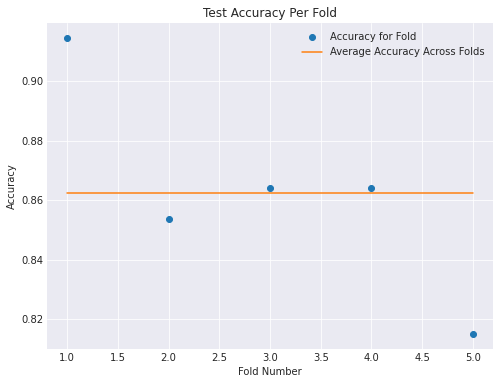

In [38]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(8,6))
plt.plot([i for i in range(1,6)], list(test_acc_per_fold.values()), 'o');
plt.plot([i for i in range(1,6)], [np.mean(list(test_acc_per_fold.values())) for i in range(1,6)]);
plt.title('Test Accuracy Per Fold');
plt.xlabel('Fold Number');
plt.ylabel('Accuracy');
plt.legend(labels = ['Accuracy for Fold', 'Average Accuracy Across Folds'], loc = 'upper right');

In [33]:
#average accuracy on test set (rerun on saved weights)
print('Average Test Accuracy for 5-fold Cross Validation: ', np.mean(list(test_acc_per_fold.values())))

Average Test Accuracy for 5-fold Cross Validation:  0.8623005270957946


---

### Plotting Model Accuracy + Loss Curves For Train + Validation Process

In [34]:
histories_per_fold

{'model_1_cv.h5': <keras.callbacks.History at 0x7fb7e4c61f70>,
 'model_2_cv.h5': <keras.callbacks.History at 0x7fb7ea413970>,
 'model_3_cv.h5': <keras.callbacks.History at 0x7fb7e43c1f40>,
 'model_4_cv.h5': <keras.callbacks.History at 0x7fb7e9b07790>,
 'model_5_cv.h5': <keras.callbacks.History at 0x7fb7d4474c70>}

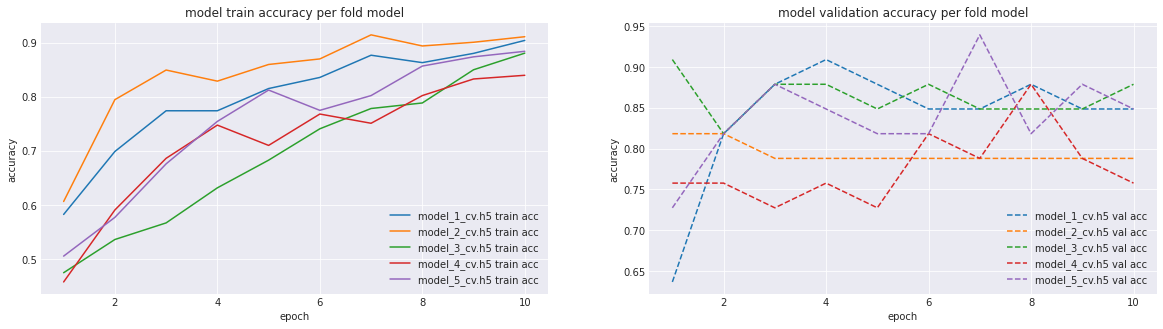

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
plt.style.use('seaborn-darkgrid')

#train acc per fold
train_acc_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    acc = history.history['accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc)
    train_acc_labels.append(f'{model_name} train acc')

ax1.set_title(f"model train accuracy per fold model");
ax1.set_ylabel('accuracy');
ax1.set_xlabel('epoch');
ax1.legend(train_acc_labels, loc='lower right');


# val acc per fold
val_acc_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax2.plot(epochs, acc, '--')
    val_acc_labels.append(f'{model_name} val acc')


ax2.set_title(f"model validation accuracy per fold model");
ax2.set_ylabel('accuracy');
ax2.set_xlabel('epoch');
ax2.legend(val_acc_labels, loc='lower right');

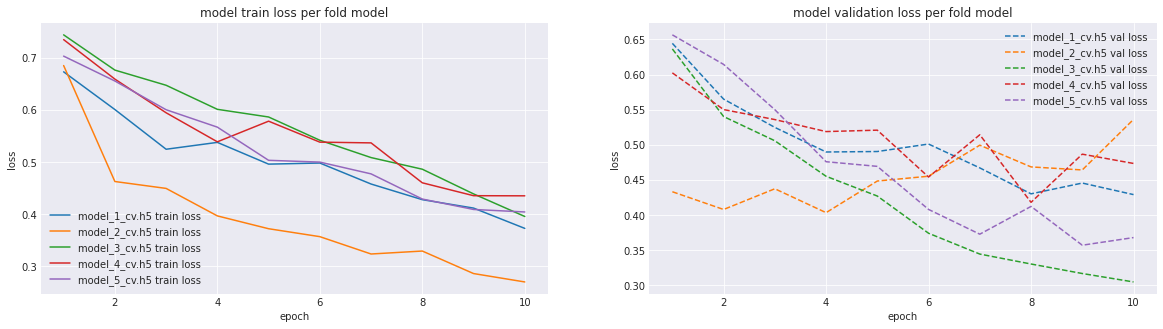

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
plt.style.use('seaborn-darkgrid')

#plot train loss
train_loss_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    ax1.plot(epochs, loss)
    train_loss_labels.append(f'{model_name} train loss')

ax1.set_title(f"model train loss per fold model");
ax1.set_ylabel('loss');
ax1.set_xlabel('epoch');
ax1.legend(train_loss_labels, loc='lower left');

#plot validation loss
val_loss_labels = []
for model_name in list(histories_per_fold.keys()):
    history = histories_per_fold[model_name]
    loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    ax2.plot(epochs, loss, '--')
    val_loss_labels.append(f'{model_name} val loss')

ax2.set_title(f"model validation loss per fold model");
ax2.set_ylabel('loss');
ax2.set_xlabel('epoch');
ax2.legend(val_loss_labels, loc='upper right');

